In [1]:
# @title AudioSR Environment Setup

import os
import subprocess
import sys
from IPython.display import display, Markdown

# ============================================================
# Configuration
# ============================================================
SWAP_SIZE_GB = 25
NUMPY_VERSION = "1.26.4"

def setup_audiosr_environment():
    display(Markdown(f"""
# AudioSR environment setup

This step prepares the runtime required for **AudioSR**.

Actions:
- Create a {SWAP_SIZE_GB} GB swap file (if not already present)
- Remove known conflicting packages in standard Colab runtimes
- Install a strictly versioned dependency stack and the AudioSR repository
"""))

    # Swap file (idempotent)
    if not os.path.exists("/swapfile"):
        try:
            subprocess.run(f"fallocate -l {SWAP_SIZE_GB}G /swapfile", shell=True, check=True)
            subprocess.run("chmod 600 /swapfile", shell=True, check=True)
            subprocess.run("mkswap /swapfile", shell=True, check=True)
            subprocess.run("swapon /swapfile", shell=True, check=True)
            subprocess.run("sysctl vm.swappiness=10", shell=True, check=True)
        except subprocess.CalledProcessError:
            pass

    # Environment pruning (intentional)
    subprocess.run(
        "pip uninstall -y tensorflow tensorflow-probability jax jaxlib",
        shell=True,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    subprocess.run(
        "pip cache purge",
        shell=True,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

    # Isolated installation script (exactly the same dependency choices)
    install_script = f"""#!/bin/bash
set -e

# Core dependencies (strict numpy pin for binary compatibility)
pip install --no-cache-dir "numpy=={NUMPY_VERSION}" "setuptools" "wheel" --only-binary=:all: --force-reinstall

# PyTorch stack
pip install --no-cache-dir torch torchaudio --index-url https://download.pytorch.org/whl/cu121

# Audio stack
pip install --no-cache-dir \\
    "diffusers" "transformers" "accelerate" "einops" \\
    "librosa>=0.10.0" "soundfile" "matplotlib" "ftfy" \\
    "unidecode" "phonemizer" "pyloudnorm" "braceexpand" "tqdm" \\
    "omegaconf==2.3.0" \\
    "pytorch_lightning==1.9.5" \\
    "taming-transformers-rom1504" \\
    "kornia" "open_clip_torch" "webdataset" "torchlibrosa" \\
    "scipy"

# AudioSR repo
rm -rf /content/versatile_audio_super_resolution
git clone https://github.com/haoheliu/versatile_audio_super_resolution.git /content/versatile_audio_super_resolution
pip install --no-deps -e /content/versatile_audio_super_resolution
"""

    with open("install_audiosr.sh", "w") as f:
        f.write(install_script)

    try:
        subprocess.run(["bash", "install_audiosr.sh"], check=True)
        display(Markdown("✅ AudioSR environment is ready."))
    except subprocess.CalledProcessError:
        display(Markdown("❌ Installation failed. Check the cell output above."))
        raise RuntimeError("Environment setup failed.")

setup_audiosr_environment()



# AudioSR environment setup

This step prepares the runtime required for **AudioSR**.

Actions:
- Create a 25 GB swap file (if not already present)
- Remove known conflicting packages in standard Colab runtimes
- Install a strictly versioned dependency stack and the AudioSR repository


✅ AudioSR environment is ready.


# AudioSR inference

AudioSR is used here strictly as a **bandwidth extension stage**, not as a creative effect.

Objective: extend high-frequency content while preserving:
- timing and synchronization
- in-band structure
- spectral continuity


✅ Inference completed successfully.

Memory cleared.


# Contextual analysis (spectral difference)

This section provides a visual comparison between input and AudioSR output.
The analysis does not aim to rate quality, but to check consistency with the intended behavior.

Expected behavior
- Additional high-frequency content that follows musical events
- Limited in-band disturbance
- No stationary broadband hiss across time

Undesired behavior
- Broad in-band reshaping unrelated to events
- Stationary high-frequency noise (hiss-like layer)
- Obvious block boundary artifacts


## Full-band time–frequency comparison

The plots below show:
- Input signal (pre-upscale)
- Output signal (AudioSR, gain-matched)
- Local spectral differences (PRE − POST)

Note: the difference map is a visualization aid. The input dB map is resized to match the output grid.

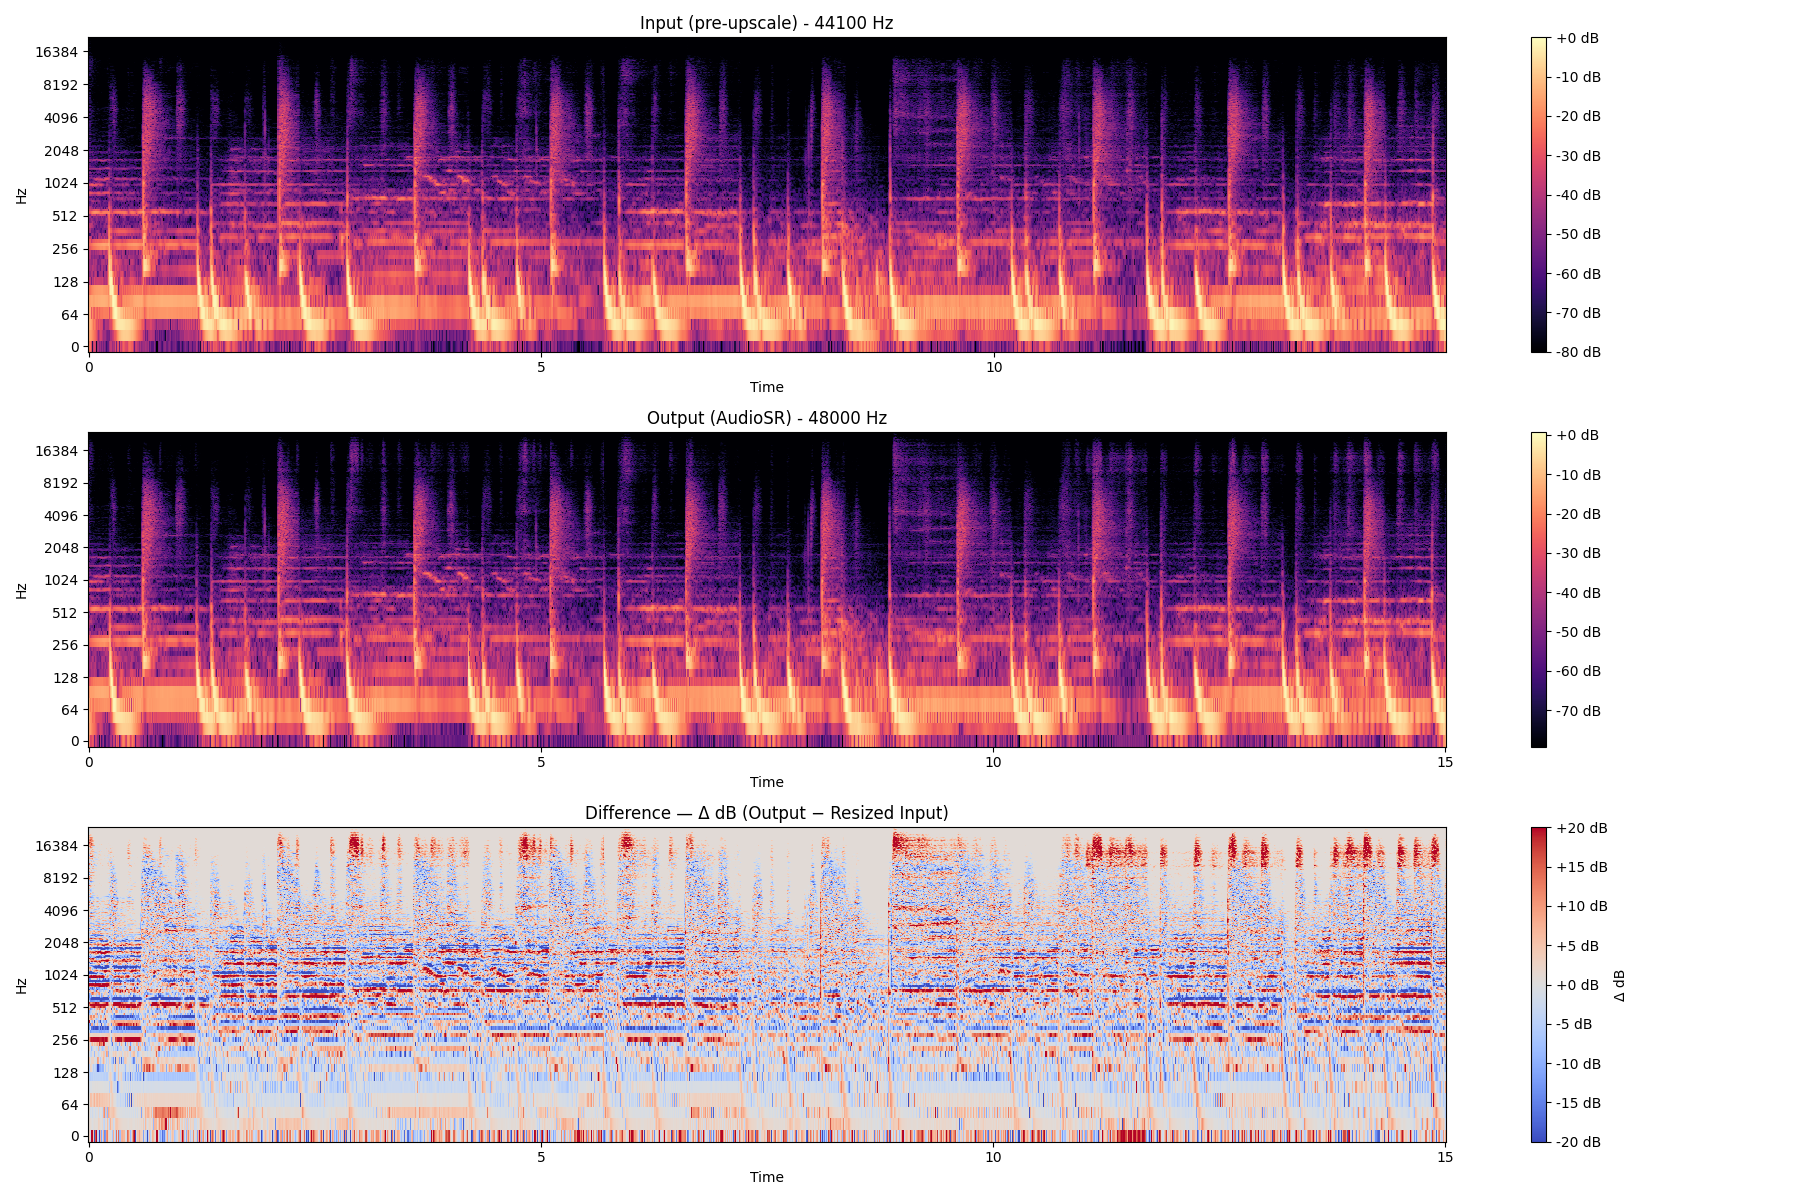

## Comparative listening

The following players correspond to the signals used in the plots above.

**Input — Pre-upscale**

**Output — AudioSR**

In [2]:
# @title AudioSR Inference & Contextual Analysis

import os
import subprocess
import sys
import torch
import gc
from IPython.display import Audio, Image, display, Markdown

# ============================================================
# User parameters
# ============================================================
INPUT_PATH      = "/content/apollo_0.wav"    # @param {"type":"string"}
OUTPUT_PATH     = "/content/audiosr_0.wav"   # @param {"type":"string"}

CHUNK_SECONDS   = 6.0    # @param {"type":"slider", "min":4.0, "max":10.0, "step":0.5}
OVERLAP_SECONDS = 0.5    # @param {"type":"slider", "min":0.5, "max":2.0, "step":0.1}

DDIM_STEPS      = 100    # @param {"type":"slider", "min":10, "max":150, "step":5}
GUIDANCE_SCALE  = 3      # @param {"type":"slider", "min":1.0, "max":5.0, "step":0.5}

# ============================================================
# Inference
# ============================================================
def run_audiosr(in_f, out_f, chunk_sec, overlap_sec, steps, guidance):
    display(Markdown(rf"""
# AudioSR inference

AudioSR is used here strictly as a **bandwidth extension stage**, not as a creative effect.

Objective: extend high-frequency content while preserving:
- timing and synchronization
- in-band structure
- spectral continuity
"""))

    if not os.path.exists(in_f):
        display(Markdown(f"❌ Input file not found: `{in_f}`"))
        return

    # Pre-flush
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    py_inference_code = f"""
import os
import sys
import shutil
import warnings
import logging
import gc
import torch
import numpy as np
import soundfile as sf
import librosa
import torchaudio
import scipy.signal
import traceback

ERROR_LOG_FILE = "audiosr_crash.log"

def log_crash(msg):
    with open(ERROR_LOG_FILE, "w") as f:
        f.write(msg)

try:
    warnings.filterwarnings("ignore")
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    logging.getLogger("transformers").setLevel(logging.ERROR)
    logging.getLogger("diffusers").setLevel(logging.ERROR)

    class QuietBlock:
        def __enter__(self):
            self._orig_out = sys.stdout
            self._orig_err = sys.stderr
            sys.stdout = open(os.devnull, 'w')
            sys.stderr = open(os.devnull, 'w')
        def __exit__(self, exc_type, exc_val, exc_tb):
            sys.stdout.close()
            sys.stderr.close()
            sys.stdout = self._orig_out
            sys.stderr = self._orig_err

    INPUT_FILE = "{in_f}"
    OUTPUT_FILE = "{out_f}"
    CHUNK_SEC = {chunk_sec}
    OVERLAP_SEC = {overlap_sec}
    DDIM_STEPS = {steps}
    GUIDANCE_SCALE = {guidance}
    TARGET_SR = 48000
    REAL_FADE_SEC = 0.05

    def _safe_load_wrapper(filepath, **kwargs):
        data, sr = sf.read(filepath)
        tensor = torch.from_numpy(data).float()
        if tensor.ndim == 1: tensor = tensor.unsqueeze(0)
        else: tensor = tensor.t()
        return tensor, sr
    torchaudio.load = _safe_load_wrapper

    _real_ellip = scipy.signal.ellip
    def _safe_ellip(N, rp, rs, Wn, btype='low', output='sos'):
        if isinstance(Wn, (int, float, np.number)):
            if Wn >= 1.0: Wn = 0.99
        return _real_ellip(N, rp, rs, Wn, btype=btype, output=output)
    scipy.signal.ellip = _safe_ellip

    with QuietBlock():
        import audiosr.lowpass
        audiosr.lowpass.ellip = _safe_ellip
        from audiosr import build_model, super_resolution

    if not getattr(torch.load, '_is_patched', False):
        _orig_load = torch.load
        def _load_wrapper(f, map_location=None, **kwargs):
            if isinstance(f, str) and (f.endswith('.ckpt') or f.endswith('.bin')):
                 if map_location is None or map_location == 'cpu':
                     return _orig_load(f, map_location='cuda', **kwargs)
            return _orig_load(f, map_location=map_location, **kwargs)
        _load_wrapper._is_patched = True
        torch.load = _load_wrapper

    if not getattr(torch.meshgrid, '_is_patched', False):
        _orig_mesh = torch.meshgrid
        def _mesh_wrap(*args, **kwargs):
            if 'indexing' not in kwargs: kwargs['indexing'] = 'ij'
            return _orig_mesh(*args, **kwargs)
        _mesh_wrap._is_patched = True
        torch.meshgrid = _mesh_wrap

    def normalize_audio(audio_data, target_dB=-0.5):
        peak = np.max(np.abs(audio_data))
        if peak == 0: return audio_data
        target_amp = 10 ** (target_dB / 20)
        return audio_data * (target_amp / peak)

    if not os.path.exists(INPUT_FILE):
        raise FileNotFoundError(f"Input file missing: {{INPUT_FILE}}")

    with QuietBlock():
        model = build_model(model_name="basic", device="cuda")

    y, sr = librosa.load(INPUT_FILE, sr=None, mono=False)
    if len(y.shape) == 1: y = y[np.newaxis, :]
    channels, total_input_samples = y.shape

    total_output_samples = int((total_input_samples / sr) * TARGET_SR)
    final_buffer = np.zeros((channels, total_output_samples), dtype=np.float32)

    chunk_samples_in = int(CHUNK_SEC * sr)
    stride_samples_in = int(CHUNK_SEC * sr) - int(OVERLAP_SEC * sr)
    if stride_samples_in <= 0: stride_samples_in = chunk_samples_in // 2

    num_chunks = int(np.ceil(total_input_samples / stride_samples_in))
    if (num_chunks-1)*stride_samples_in + chunk_samples_in < total_input_samples: num_chunks += 1

    temp_dir = "temp_audiosr_exec"
    os.makedirs(temp_dir, exist_ok=True)
    fade_samples_out = int(REAL_FADE_SEC * TARGET_SR)

    print(f"Processing {{num_chunks}} chunks...")

    for i in range(num_chunks):
        torch.cuda.empty_cache()
        gc.collect()

        start_in = i * stride_samples_in
        end_in = min(start_in + chunk_samples_in, total_input_samples)
        if (total_input_samples - start_in) < (sr * 2.0) and end_in == total_input_samples:
             start_in = max(0, total_input_samples - chunk_samples_in)

        chunk_data = y[:, start_in:end_in]
        if chunk_data.shape[1] < sr * 1.5:
             pad = int(sr * 1.5) - chunk_data.shape[1]
             chunk_data = np.pad(chunk_data, ((0,0), (0, pad)), 'constant')

        t_path = os.path.join(temp_dir, "c.wav")
        sf.write(t_path, chunk_data.T, sr)

        print(f"Chunk {{i+1}}/{{num_chunks}}...", end="\\r", flush=True)

        with QuietBlock():
            with torch.no_grad():
                waveform = super_resolution(
                    model, t_path, seed=42, guidance_scale=GUIDANCE_SCALE,
                    ddim_steps=DDIM_STEPS, latent_t_per_second=12.8
                )

        out = waveform.squeeze().cpu().numpy() if hasattr(waveform, 'cpu') else waveform.squeeze()
        if len(out.shape) == 1: out = out[np.newaxis, :]

        start_out = int(start_in * (TARGET_SR / sr))
        curr_len = min(out.shape[1], total_output_samples - start_out)
        out = out[:, :curr_len]

        if i == 0:
            final_buffer[:, start_out:start_out+curr_len] = out
        else:
            f_len = min(fade_samples_out, curr_len)
            fade_in = np.linspace(0, 1, f_len)
            prev_zone = final_buffer[:, start_out:start_out+f_len]
            final_buffer[:, start_out:start_out+f_len] = (prev_zone * (1-fade_in)) + (out[:, :f_len] * fade_in)
            final_buffer[:, start_out+f_len:start_out+curr_len] = out[:, f_len:]

        os.remove(t_path)
        del waveform

    final_buffer = normalize_audio(final_buffer)
    sf.write(OUTPUT_FILE, final_buffer.T, TARGET_SR)
    shutil.rmtree(temp_dir, ignore_errors=True)

    del model
    gc.collect()
    torch.cuda.empty_cache()

except Exception:
    err_msg = traceback.format_exc()
    log_crash(err_msg)
    sys.exit(1)
"""
    with open("run_audiosr.py", "w") as f:
        f.write(py_inference_code)

    try:
        subprocess.run(["pip", "install", "numpy<2"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False)
        subprocess.run(["python", "run_audiosr.py"], check=True)
        display(Markdown("✅ Inference completed successfully."))
    except subprocess.CalledProcessError:
        if os.path.exists("audiosr_crash.log"):
            with open("audiosr_crash.log", "r") as f:
                error_content = f.read()
            display(Markdown("❌ Inference failed. Details below:"))
            print("-" * 40)
            print(error_content)
            print("-" * 40)
        else:
            display(Markdown("❌ Inference failed. (System OOM or unknown error)"))
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        display(Markdown("Memory cleared."))

# ============================================================
# Contextual analysis
# ============================================================
def contextual_check(in_path: str, out_path: str):
    display(Markdown(r"""
# Contextual analysis (spectral difference)

This section provides a visual comparison between input and AudioSR output.
The analysis does not aim to rate quality, but to check consistency with the intended behavior.

Expected behavior
- Additional high-frequency content that follows musical events
- Limited in-band disturbance
- No stationary broadband hiss across time

Undesired behavior
- Broad in-band reshaping unrelated to events
- Stationary high-frequency noise (hiss-like layer)
- Obvious block boundary artifacts
"""))

    if not os.path.exists(out_path):
        return

    display(Markdown(
        "## Full-band time–frequency comparison\n\n"
        "The plots below show:\n"
        "- Input signal (pre-upscale)\n"
        "- Output signal (AudioSR, gain-matched)\n"
        "- Local spectral differences (PRE − POST)\n\n"
        "Note: the difference map is a visualization aid. The input dB map is resized to match the output grid."
    ))

    py_analysis_code = f"""
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import cv2
import warnings
import sys

warnings.filterwarnings("ignore")

INPUT_PATH = "{in_path}"
OUTPUT_PATH = "{out_path}"
IMG_OUT = "analysis_result.png"
N_FFT = 2048
HOP = 512
DIFF_DB_RANGE = 20.0

try:
    x_in, sr_in = librosa.load(INPUT_PATH, sr=None, mono=True)
    x_out, sr_out = librosa.load(OUTPUT_PATH, sr=None, mono=True)

    min_dur = min(len(x_in)/sr_in, len(x_out)/sr_out)
    x_in = x_in[:int(min_dur*sr_in)]
    x_out = x_out[:int(min_dur*sr_out)]

    rms_in = np.sqrt(np.mean(x_in**2))
    rms_out = np.sqrt(np.mean(x_out**2))
    gain_comp = rms_in / max(rms_out, 1e-12)
    x_out_m = x_out * gain_comp

    S_in = np.abs(librosa.stft(x_in, n_fft=N_FFT, hop_length=HOP))
    S_out = np.abs(librosa.stft(x_out_m, n_fft=N_FFT, hop_length=HOP))

    ref = np.max(S_in)
    D_in = librosa.amplitude_to_db(S_in, ref=ref)
    D_out = librosa.amplitude_to_db(S_out, ref=ref)

    D_in_resized = cv2.resize(D_in, (D_out.shape[1], D_out.shape[0]), interpolation=cv2.INTER_LINEAR)
    D_diff = D_out - D_in_resized

    plt.figure(figsize=(18, 12))

    plt.subplot(3, 1, 1)
    librosa.display.specshow(D_in, sr=sr_in, hop_length=HOP, x_axis='time', y_axis='log', cmap='magma')
    plt.title(f"Input (pre-upscale) - {{sr_in}} Hz")
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(3, 1, 2)
    librosa.display.specshow(D_out, sr=sr_out, hop_length=HOP, x_axis='time', y_axis='log', cmap='magma')
    plt.title(f"Output (AudioSR) - {{sr_out}} Hz")
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(3, 1, 3)
    librosa.display.specshow(D_diff, sr=sr_out, hop_length=HOP, x_axis='time', y_axis='log',
                             cmap='coolwarm', vmin=-DIFF_DB_RANGE, vmax=DIFF_DB_RANGE)
    plt.title("Difference — Δ dB (Output − Resized Input)")
    plt.colorbar(format='%+2.0f dB', label='Δ dB')

    plt.tight_layout()
    plt.savefig(IMG_OUT)

except Exception as e:
    with open("analysis_error.log", "w") as f:
        f.write(str(e))
    sys.exit(1)
"""
    with open("run_analysis.py", "w") as f:
        f.write(py_analysis_code)

    subprocess.run(["pip", "install", "opencv-python-headless", "numpy<2"],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    try:
        subprocess.run(["python", "run_analysis.py"], check=True)

        if os.path.exists("analysis_result.png"):
            display(Image("analysis_result.png"))

        display(Markdown("## Comparative listening\n\nThe following players correspond to the signals used in the plots above."))
        display(Markdown("**Input — Pre-upscale**"))
        display(Audio(in_path))
        display(Markdown("**Output — AudioSR**"))
        display(Audio(out_path))

    except subprocess.CalledProcessError:
        if os.path.exists("analysis_error.log"):
            with open("analysis_error.log", "r") as f:
                print(f"Analysis error: {f.read()}")
        else:
            print("Analysis failed (unknown error).")

# ============================================================
# Run
# ============================================================
run_audiosr(INPUT_PATH, OUTPUT_PATH, CHUNK_SECONDS, OVERLAP_SECONDS, DDIM_STEPS, GUIDANCE_SCALE)
contextual_check(INPUT_PATH, OUTPUT_PATH)
